In [1]:
# !pip install --upgrade numpy scipy scikit-learn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
# from pyod.models.gmm import GMM
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from pyod.models.iforest import IForest
# from pyod.models.gmm import GMM
# from sklearn.svm import OneClassSVM
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense
# import numpy as np
# from sklearn.model_selection import train_test_split


In [3]:
import json

def extract_sites_by_city(json_file, city_name="Mumbai"):
    """Extracts sites from a given city in the JSON file."""
    with open(json_file, "r", encoding="utf-8") as file:
        data = json.load(file)
    
    # Filtering sites for the given city
    city_sites = [site for site in data if site.get("city") == city_name]

    # Display the extracted sites
    if not city_sites:
        print(f"No sites found for {city_name}")
        return []
    
    # print(f"Sites in {city_name}:")
    # for site in city_sites:
    #     print(f"- {site['name']} (ID: {site['id']}, Lat: {site['lat']}, Lon: {site['lon']})")
    
    return city_sites  # Returns the list of sites

# Example usage:
json_file = "site_ids.json"  # Your uploaded file path
mumbai_sites = extract_sites_by_city(json_file, "Mumbai")
delhi_sites = extract_sites_by_city(json_file, "Delhi")
kolkata_sites = extract_sites_by_city(json_file, "Kolkata")
hyderabad_sites = extract_sites_by_city(json_file, "Hyderabad")
bengaluru_sites = extract_sites_by_city(json_file, "Bengaluru")


In [4]:
import pandas as pd
import glob
import os

def load_and_prepare_mumbai_data(csv_folder="csvs/"):
    """
    Reads all CSV files from the 'csvs/' folder belonging to Mumbai sites, 
    merges them into a single DataFrame, sets dt_time as datetime index, and sorts by timestamp.
    Returns a cleaned DataFrame.
    """
    # Ensure folder path has correct format
    csv_folder = csv_folder.rstrip("/") + "/"  

    # Find all CSV files inside the csvs folder
    csv_files = glob.glob(os.path.join(csv_folder, "site_*.csv"))  # Adjust if filenames are different

    if not csv_files:
        print("❌ No CSV files found in the 'csvs/' folder.")
        return None

    df_list = []

    for file in csv_files:
        df = pd.read_csv(file)

        # Extract site ID from filename (assuming format: siteID_data.csv)
        site_id = os.path.basename(file).split("_data.csv")[0]
        df["site_id"] = site_id  # Store site ID in the DataFrame

        df_list.append(df)

    # Merge all DataFrames
    combined_df = pd.concat(df_list, ignore_index=True)

    # Convert dt_time column to datetime format
    combined_df["dt_time"] = pd.to_datetime(combined_df["dt_time"], errors="coerce")

    # Drop rows with invalid timestamps
    combined_df = combined_df.dropna(subset=["dt_time"])

    # Set dt_time as index and sort
    combined_df = combined_df.set_index("dt_time").sort_index()

    print(f"Loaded {len(combined_df)} records from {len(csv_files)} CSV files.")

    return combined_df

# Load and prepare Mumbai data from 'csvs/' folder
mumbai_df = load_and_prepare_mumbai_data("csvs/")


Loaded 766285 records from 13 CSV files.


In [5]:
import pandas as pd
import numpy as np

def clean_and_prepare(df):
    """
    Cleans and prepares the dataframe:
    - Ensures datetime index
    - Converts numeric data before interpolation
    - Creates time-based features (hour, sin_hour, cos_hour)
    - Adds lag features for pm2.5cnc and pm10cnc
    - Handles missing values correctly
    """

    if isinstance(df.index, pd.MultiIndex):
        dt_index = pd.to_datetime(df.index.get_level_values(0), errors="coerce")
        df.index = df.index.set_levels(dt_index, level=0)
    else:
        if "dt_time" in df.columns:
            df["dt_time"] = pd.to_datetime(df["dt_time"], errors="coerce")
            df.dropna(subset=["dt_time"], inplace=True)
            df.set_index("dt_time", inplace=True)

    if "pm2.5cnc" not in df.columns or "pm10cnc" not in df.columns:
        print(f"Warning: One or both pollutant columns are missing! Columns available: {df.columns}")

    for col in ["pm2.5cnc", "pm10cnc"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df = df[numeric_cols]

    if isinstance(df.index, pd.MultiIndex) and "site_id" in df.columns:
        df.set_index("site_id", append=True, inplace=True)

    if not df.empty:
        df.interpolate(method="time", inplace=True)

    df["hour"] = df.index.get_level_values(0).hour
    df["sin_hour"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["cos_hour"] = np.cos(2 * np.pi * df["hour"] / 24)

    for col in ["pm2.5cnc", "pm10cnc"]:
        if col in df.columns:
            df[f"{col}_lag1"] = df[col].shift(1).bfill()
            df[f"{col}_lag2"] = df[col].shift(2).bfill()

    df["month"] = df.index.get_level_values(0).month

    def get_season(month):
        if month in [1, 2]: return "Winter"
        elif month in [6, 7, 8, 9]: return "Monsoon"
        else: return "Post-Monsoon"

    df["season"] = df["month"].apply(get_season)
    df["season_code"] = pd.Categorical(df["season"]).codes
    df.drop(columns=["season"], inplace=True)

    df.fillna(method="ffill", inplace=True)
    df.fillna(method="bfill", inplace=True)

    if "pm2.5cnc" not in df.columns:
        raise ValueError("ERROR: 'pm2.5cnc' column is missing from DataFrame after processing!")

    return df


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def encode_pm25(pm25):
    """
    Encodes PM2.5 value into a numeric score:
      1: Good (0–30 µg/m³)
      2: Satisfactory (31–60 µg/m³)
      3: Moderate (61–90 µg/m³)
      4: Poor (91–120 µg/m³)
      5: Very Poor (121–250 µg/m³)
      6: Severe (251 µg/m³ and above)
    """
    if pm25 <= 30:
        return 1
    elif pm25 <= 60:
        return 2
    elif pm25 <= 90:
        return 3
    elif pm25 <= 120:
        return 4
    elif pm25 <= 250:
        return 5
    else:
        return 6

def encode_pm10(pm10):
    """
    Encodes PM10 value into a numeric score:
      1: Good (0–50 µg/m³)
      2: Satisfactory (51–100 µg/m³)
      3: Moderately Polluted (101–250 µg/m³)
      4: Poor (251–350 µg/m³)
      5: Very Poor (351–430 µg/m³)
      6: Severe (431 µg/m³ and above)
    """
    if pm10 <= 50:
        return 1
    elif pm10 <= 100:
        return 2
    elif pm10 <= 250:
        return 3
    elif pm10 <= 350:
        return 4
    elif pm10 <= 430:
        return 5
    else:
        return 6

def combined_air_quality_label(pm25, pm10):
    """
    Combines PM2.5 and PM10 numeric scores by taking the floor of the average.
    For example, if one pollutant is 'Severe' (6) and the other 'Moderate' (3),
    the average (4.5) is floored to 4, which we interpret as 'Poor'.
    """
    score_pm25 = encode_pm25(pm25)
    score_pm10 = encode_pm10(pm10)
    combined_score = (score_pm25 + score_pm10) // 2
    return combined_score


combined_labels = {
    1: "Good",
    2: "Satisfactory",
    3: "Moderate",
    4: "Poor",
    5: "Very Poor",
    6: "Severe"
}

def process_air_quality_data(df):
    """
    Processes a DataFrame containing 'pm25' and 'pm10' columns:
      - Encodes each pollutant into its numeric score.
      - Creates a combined score.
      - Retains only numeric columns.
    """
    df['pm25_numeric'] = df['pm25'].apply(encode_pm25)
    df['pm10_numeric'] = df['pm10'].apply(encode_pm10)
    df['combined_numeric'] = df.apply(
        lambda row: combined_air_quality_label(row['pm25'], row['pm10']),
        axis=1
    )
    df['combined_label'] = df['combined_numeric'].map(combined_labels)
    
    # Keep only numeric columns (if desired)
    df_numeric = df.select_dtypes(include=[np.number])
    return df_numeric



def check_misclassification(row, pollutant):
    """
    Identifies if the anomaly detection for a row is a misclassification.
    
    Logic:
      - Computes the combined numeric air quality label using both 'pm2.5cnc' and 'pm10cnc' columns.
      - If an anomaly is flagged (column value 1) but the combined label is in a milder category (1, 2, or 3),
        it is a misclassification.
      - If no anomaly is flagged (0) but the combined label is in a worse category (4, 5, or 6),
        it is a misclassification.
    
    Returns:
      - True if misclassification, False otherwise.
    """
    # Compute combined numeric label from the pollutant values (assumes both columns are available)
    combined = combined_air_quality_label(row["pm2.5cnc"], row["pm10cnc"])
    
    # Determine the anomaly flag column (e.g., "Anomaly_pm25cnc_features" for "pm2.5cnc")
    anomaly_col = f"Anomaly_{pollutant.replace('.', '')}"
    anomaly_flag = row[anomaly_col]
    
    if anomaly_flag == 1 and combined in [1, 2, 3]:
        return True
    # elif anomaly_flag == 0 and combined in [4, 5, 6]:
    #     return True
    else:
        return False

In [7]:
def run_isoforest(train_data):
    """
    Trains an Isolation Forest on the given training data.
    Converts detected anomalies (-1) to normal (1) only if they fall within safe AQI ranges:
      - For 'pm2.5cnc': safe range is 0 to 90.
      - For 'pm10cnc': safe range is 0 to 350.
    Returns: (model, scores, labels)
    """
    # Train the model
    model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
    model.fit(train_data)
    
    # Get outputs from Isolation Forest
    scores = model.decision_function(train_data)  # Higher => more normal
    labels = model.predict(train_data)              # 1 => normal, -1 => anomaly

    # safe_range_mask = None
    # if 'pm2.5cnc' in train_data.columns and 'pm10cnc' in train_data.columns:
    #     mask_pm25 = (train_data["pm2.5cnc"] >= 0) & (train_data["pm2.5cnc"] <= 90)
    #     mask_pm10 = (train_data["pm10cnc"] >= 0) & (train_data["pm10cnc"] <= 350)
    #     safe_range_mask = mask_pm25 & mask_pm10
    # elif 'pm2.5cnc' in train_data.columns:
    #     safe_range_mask = (train_data["pm2.5cnc"] >= 0) & (train_data["pm2.5cnc"] <= 90)
    # elif 'pm10cnc' in train_data.columns:
    #     safe_range_mask = (train_data["pm10cnc"] >= 0) & (train_data["pm10cnc"] <= 350)
    
    # # For rows flagged as anomaly (-1) but within the safe range, force them to normal (1)
    # if safe_range_mask is not None:
    #     labels = np.where((labels == -1) & safe_range_mask, 1, labels)
    
    return model, scores, labels


# def run_svm(train_data):
#     """
#     Trains a One-Class SVM on the given training data.
#     Converts detected anomalies (-1) to normal (1) only if they fall within safe AQI ranges:
#       - For 'pm2.5cnc': safe range is 0 to 90.
#       - For 'pm10cnc': safe range is 0 to 350.
#     Returns: (model, scores, labels)
#     """
#     # Train the model
#     model = OneClassSVM(nu=0.05, kernel="rbf", gamma="scale")
#     model.fit(train_data)
    
#     # Get outputs from One-Class SVM
#     scores = model.decision_function(train_data)  # Higher => more normal
#     labels = model.predict(train_data)              # 1 => normal, -1 => anomaly

#     # Define safe range mask based on available pollutant columns
#     safe_range_mask = None
#     if 'pm2.5cnc' in train_data.columns and 'pm10cnc' in train_data.columns:
#         mask_pm25 = (train_data["pm2.5cnc"] >= 0) & (train_data["pm2.5cnc"] <= 250)
#         mask_pm10 = (train_data["pm10cnc"] >= 0) & (train_data["pm10cnc"] <= 350)
#         safe_range_mask = mask_pm25 & mask_pm10
#     elif 'pm2.5cnc' in train_data.columns:
#         safe_range_mask = (train_data["pm2.5cnc"] >= 0) & (train_data["pm2.5cnc"] <= 250)
#     elif 'pm10cnc' in train_data.columns:
#         safe_range_mask = (train_data["pm10cnc"] >= 0) & (train_data["pm10cnc"] <= 350)
    
#     # For rows flagged as anomaly (-1) but within the safe range, force them to normal (1)
#     if safe_range_mask is not None:
#         labels = np.where((labels == -1) & safe_range_mask, 1, labels)
    
#     return model, scores, labels

def split_data_random(df):
    """
    Splits the dataset into train (70%), test (20%), and validation (10%).

    Parameters:
    df (DataFrame): The dataset to split.

    Returns:
    train (DataFrame): 70% of data for training.
    test (DataFrame): 20% of data for testing.
    validation (DataFrame): 10% of data for final validation.
    """
    train, temp = train_test_split(df, test_size=0.3, random_state=42)  # 70% train, 30% temp
    test, validation = train_test_split(temp, test_size=1/3, random_state=42)  # 20% test, 10% validation
    return train, test, validation

def split_data(df):
    """
    Splits the dataset into train (70%), test (20%), and validation (10%) 
    in a historical order (earliest to latest).
    
    Parameters:
    df (DataFrame): The dataset to split. Assumes it is sorted by timestamp.
    
    Returns:
    train (DataFrame): First 70% of data for training.
    test (DataFrame): Next 20% of data for testing.
    validation (DataFrame): Final 10% of data for validation.
    """
    # Ensure data is sorted by timestamp (assuming a 'timestamp' column exists)
    df = df.sort_values(by='dt_time')

    # Compute split indices
    n = len(df)
    train_end = int(n * 0.7)
    test_end = int(n * 0.9)  # 70% train + 20% test = 90%, remaining 10% is validation

    # Split sequentially
    train = df.iloc[:train_end]
    test = df.iloc[train_end:test_end]
    validation = df.iloc[test_end:]

    return train, test, validation

In [8]:
import matplotlib.pyplot as plt

def plot_zoomed_anomalies(df, start_date, end_date, pollutant):
    anomaly_col = "Anomaly"  # Fixed syntax error

    if anomaly_col not in df.columns:
        raise KeyError(f"No anomaly column found. Available columns: {df.columns}")
    
    # Filter DataFrame for the specified date range
    df_filtered = df.loc[start_date:end_date]
    
    plt.figure(figsize=(12, 6))
    plt.plot(df_filtered.index, df_filtered[pollutant], label=pollutant, color='blue')
    
    # Highlight anomalies using the found anomaly column
    anomalies = df_filtered[df_filtered[anomaly_col] == 1]
    plt.scatter(anomalies.index, anomalies[pollutant], color='red', label="Anomaly", marker='o')
    
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title(f"Zoomed Anomalies for {pollutant}")
    plt.legend()
    plt.grid()
    plt.show()


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def process_and_plot_anomalies(df, pollutant):
    """
    Anomaly detection pipeline for PM2.5 or PM10 using Isolation Forest.
    
    Parameters:
      - df: DataFrame containing the air quality data.
      - pollutant: Either "pm2.5cnc" or "pm10cnc".
      
    Returns:
      - Updated DataFrame with anomaly labels.
    """

    # Validate pollutant
    if pollutant not in ["pm2.5cnc", "pm10cnc"]:
        raise ValueError("Invalid pollutant. Choose 'pm2.5cnc' or 'pm10cnc'.")

    # Define anomaly column name (e.g., "Anomaly_pm25cnc")
    anomaly_col = f"Anomaly_{pollutant.replace('.', '')}"

    # 🛠️ Data Cleaning & Preparation
    df_clean = clean_and_prepare(df)
    df_clean = df_clean.infer_objects(copy=False)  # Fix FutureWarning

    # Ensure datetime index (reset MultiIndex if needed)
    if isinstance(df_clean.index, pd.MultiIndex):
        df_for_split = df_clean.reset_index(level=1, drop=True)
    else:
        df_for_split = df_clean.copy()

    # 🏆 Split data (Train 70%, Test 20%, Validation 10%)
    train, test, validation = split_data_random(df_for_split)

    # Select the pollutant column
    train_data = train[[pollutant]]
    test_data = test[[pollutant]]
    val_data = validation[[pollutant]]

    # 🎯 Run Isolation Forest Model
    model, train_scores, train_labels = run_isoforest(train_data)
    _, test_scores, test_labels = run_isoforest(test_data)
    _, val_scores, val_labels = run_isoforest(val_data)

    # Convert anomaly labels: 1 = anomaly, 0 = normal
    train["Anomaly"] = (train_labels == -1).astype(int)
    test["Anomaly"] = (test_labels == -1).astype(int)
    validation["Anomaly"] = (val_labels == -1).astype(int)

    # 🔥 Ensure indices match before merging
    train.reset_index(inplace=True)
    test.reset_index(inplace=True)
    validation.reset_index(inplace=True)
    df_clean.reset_index(inplace=True)

    # Merge anomalies back
    df_clean[anomaly_col] = 0  # Default: no anomaly
    df_clean = df_clean.merge(train[["dt_time", "Anomaly"]], on="dt_time", how="left").fillna(0)
    df_clean = df_clean.merge(test[["dt_time", "Anomaly"]], on="dt_time", how="left").fillna(0)
    df_clean = df_clean.merge(validation[["dt_time", "Anomaly"]], on="dt_time", how="left").fillna(0)

    # Set back the datetime index
    df_clean.set_index("dt_time", inplace=True)

    # 📈 Plot anomalies
    plt.figure(figsize=(12, 5))
    plt.scatter(train["dt_time"], train[pollutant], c=train["Anomaly"], cmap="coolwarm", label="Train", s=15)
    plt.title(f"{pollutant.upper()} Concentration Anomalies (Isolation Forest)")
    plt.xlabel("Time")
    plt.ylabel(f"{pollutant} Concentration")
    plt.legend()
    plt.show()

    # ✅ Print anomaly counts
    print(f"Train anomalies ({pollutant}): {train['Anomaly'].sum()}")
    print(f"Test anomalies ({pollutant}): {test['Anomaly'].sum()}")
    print(f"Validation anomalies ({pollutant}): {validation['Anomaly'].sum()}")

    return df_clean


C:\Users\21til\AppData\Local\Temp\ipykernel_15952\1892353710.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.interpolate(method="time", inplace=True)
C:\Users\21til\AppData\Local\Temp\ipykernel_15952\1892353710.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hour"] = df.index.get_level_values(0).hour
C:\Users\21til\AppData\Local\Temp\ipykernel_15952\1892353710.py:59: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
C:\U

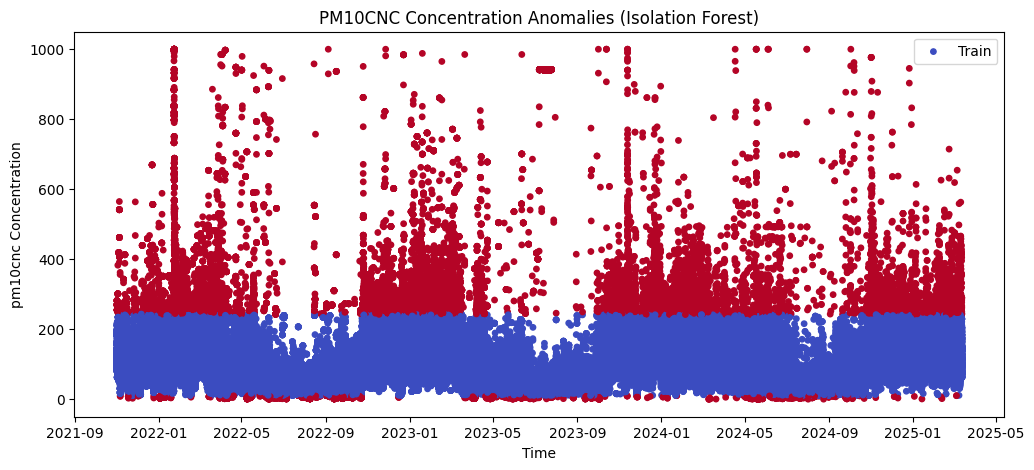

Train anomalies (pm10cnc): 26801
Test anomalies (pm10cnc): 7654
Validation anomalies (pm10cnc): 3829


In [10]:
mumbaidf10iforest = process_and_plot_anomalies(mumbai_df, pollutant="pm10cnc")


In [11]:
mumbaidf10iforest['Anomaly'].unique()

array([0., 1.])

C:\Users\21til\AppData\Local\Temp\ipykernel_15952\1892353710.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.interpolate(method="time", inplace=True)
C:\Users\21til\AppData\Local\Temp\ipykernel_15952\1892353710.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hour"] = df.index.get_level_values(0).hour
C:\Users\21til\AppData\Local\Temp\ipykernel_15952\1892353710.py:59: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
C:\U

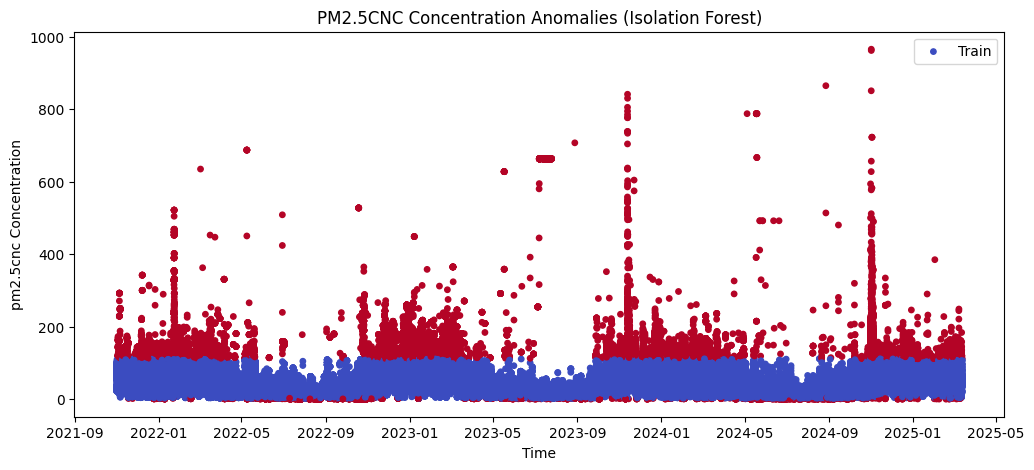

Train anomalies (pm2.5cnc): 26723
Test anomalies (pm2.5cnc): 7660
Validation anomalies (pm2.5cnc): 3826


In [12]:
mumbaidf25iforest = process_and_plot_anomalies(mumbai_df,pollutant="pm2.5cnc")

In [13]:
# plot_zoomed_anomalies(mumbaidf10iforest, "2025-03-10", "2025-03-11", "pm2.5cnc")
